# EdgeR - Non-rarefied & abundance-filtered data 

In [20]:
library(edgeR)
library(phyloseq)
library(tidyverse)
library(metagMisc)
library(microViz)
library(conflicted)
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)
library(pheatmap)

Loading required package: viridisLite



In [21]:
conflict_prefer("count","dplyr")
conflict_prefer("filter","dplyr")

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::count over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.


In [458]:
#Import miscellaneous functions for plots and edgeR
source("../../FlagellinDiversity/plots_functions.r")

In [312]:
nonrare.psAll.filt = readRDS("../filter_taxa_All_count.rds")

In [313]:
nonrare.psAll.filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1453 taxa and 772 samples ]
sample_data() Sample Data:       [ 772 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1453 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1453 tips and 1452 internal nodes ]

In [ ]:
tax_table_nonrare = as.data.frame(nonrare.psAll.filt@tax_table)%>%
rownames_to_column(var="Accession")

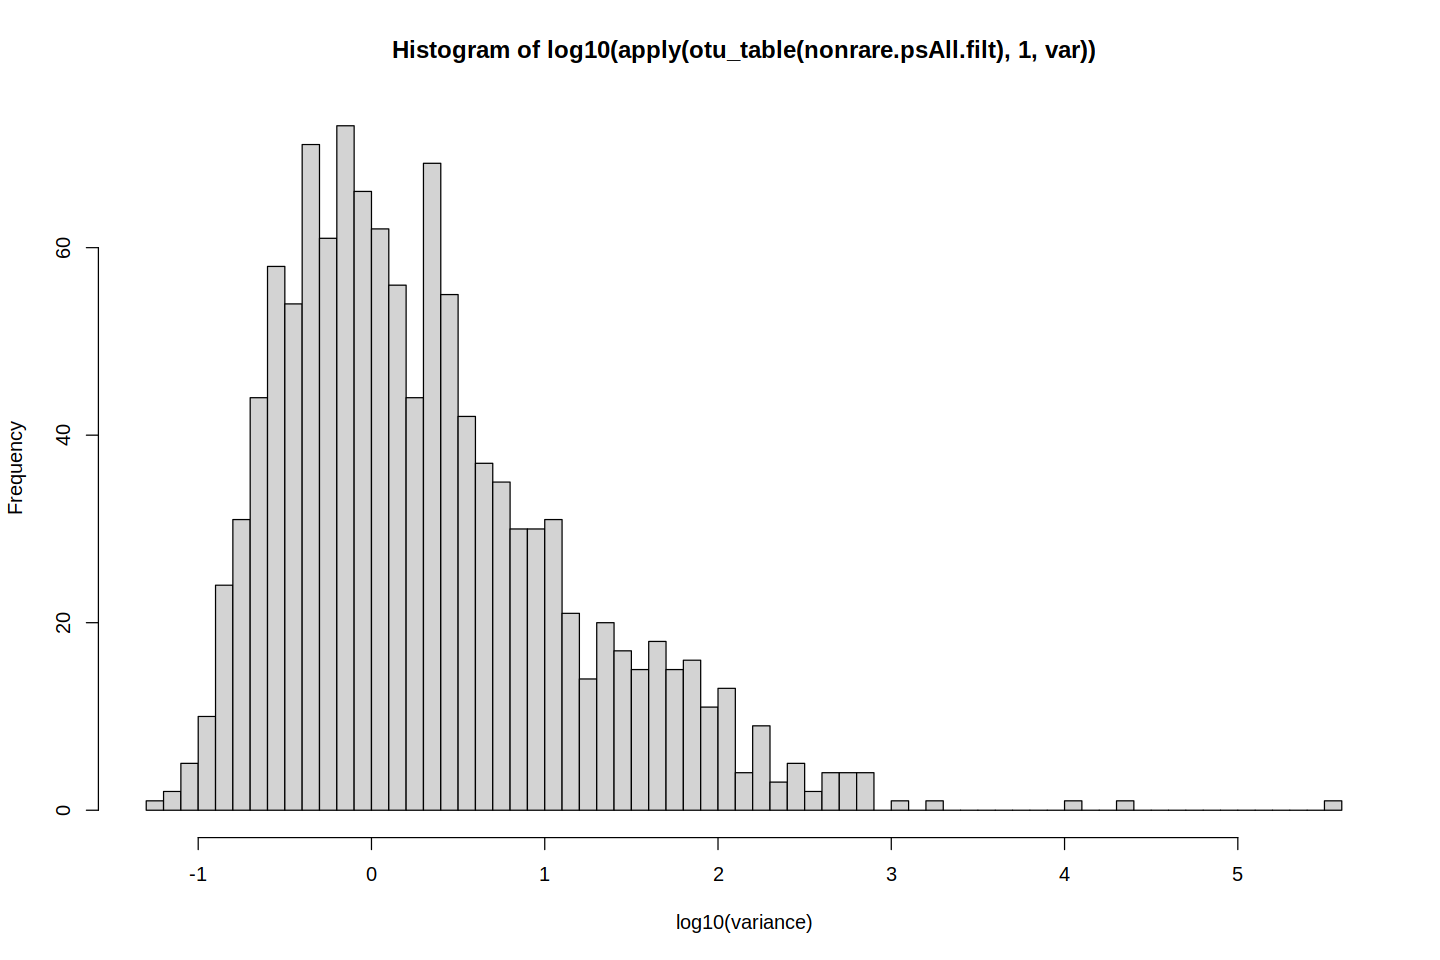

In [ ]:
# #relative abundances
hist(log10(apply(otu_table(nonrare.psAll.filt), 1, var)),
     xlab="log10(variance)",breaks=50)#,
     #main="A large fraction of OTUs have very low variance")

### Create functions

In [26]:
################################################################################
#' Convert phyloseq OTU count data into DGEList for edgeR package
#' 
#' Further details.
#' 
#' @param physeq (Required).  A \code{\link{phyloseq-class}} or
#'  an \code{\link{otu_table-class}} object. 
#'  The latter is only appropriate if \code{group} argument is also a 
#'  vector or factor with length equal to \code{nsamples(physeq)}.
#'  
#' @param group (Required). A character vector or factor giving the experimental
#'  group/condition for each sample/library. Alternatively, you may provide
#'  the name of a sample variable. This name should be among the output of
#'  \code{sample_variables(physeq)}, in which case
#'  \code{get_variable(physeq, group)} would return either a character vector or factor.
#'  This is passed on to \code{\link[edgeR]{DGEList}},
#'  and you may find further details or examples in its documentation.
#'  
#' @param method (Optional). The label of the edgeR-implemented normalization to use.
#'  See \code{\link[edgeR]{calcNormFactors}} for supported options and details. 
#'  The default option is \code{"RLE"}, which is a scaling factor method 
#'  proposed by Anders and Huber (2010).
#'  At time of writing, the \link[edgeR]{edgeR} package supported 
#'  the following options to the \code{method} argument:
#'  
#'  \code{c("TMM", "RLE", "upperquartile", "none")}.
#'
#' @param ... Additional arguments passed on to \code{\link[edgeR]{DGEList}}
#' 
#' @examples
#' 
phyloseq_to_edgeR = function(physeq, group, method="RLE", ...){
  require("edgeR")
  require("phyloseq")
  # Enforce orientation.
  if( !taxa_are_rows(physeq) ){ physeq <- t(physeq) }
  x = as(otu_table(physeq), "matrix")
  # Add one to protect against overflow, log(0) issues.
  x = x + 1
  # Check `group` argument
  if( identical(all.equal(length(group), 1), TRUE) & nsamples(physeq) > 1 ){
    # Assume that group was a sample variable name (must be categorical)
    group = get_variable(physeq, group)
  }
  # Define gene annotations (`genes`) as tax_table
  taxonomy = tax_table(physeq, errorIfNULL=FALSE)
  if( !is.null(taxonomy) ){
    taxonomy = data.frame(as(taxonomy, "matrix"))
  } 
  # Now turn into a DGEList
  y = DGEList(counts=x, group=group, genes=taxonomy, remove.zeros = TRUE, ...)
  # Calculate the normalization factors
  z = calcNormFactors(y, method=method)
  # Check for division by zero inside `calcNormFactors`
  if( !all(is.finite(z$samples$norm.factors)) ){
    stop("Something wrong with edgeR::calcNormFactors on this data,
         non-finite $norm.factors, consider changing `method` argument")
  }
  # Estimate dispersions
  return(estimateTagwiseDisp(estimateCommonDisp(z)))
}
################################################################################

In [220]:
### Perform differntially abundance analysis using EdgeR ####
### @param phyloseq_obj phyloseq_class object
### @param varianceThreshold a double vector, default=1e-5
### @param groupToCompare A character vector or factor giving the experimental group/condition for each sample/library

runEdgeR = function(phyloseq_obj,varianceThreshold=NULL,groupToCompare){

varianceThreshold = 1e-5
keepOTUs = names(which(apply(otu_table(phyloseq_obj), 1, var) > varianceThreshold))
filter_taxa = prune_taxa(keepOTUs, phyloseq_obj)

dge = phyloseq_to_edgeR(filter_taxa, group=groupToCompare)
# Perform binary test
et = exactTest(dge)
# Extract values from test results
tt = topTags(et, n=nrow(dge$table), adjust.method="BH", sort.by="PValue")
res = tt@.Data[[1]]
alpha = 0.001
sigtab = res[(res$FDR < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(rarefied.psAll.filt)[rownames(sigtab), ], "matrix"))
#dim(sigtab)
    print(tt$comparison)
    print(tt$adjust.method)
    print(tt$test)

    sigtab=filter(res,FDR<0.01)
    
#Sort results
sigtabgen = subset(sigtab, !is.na(Genus))

# Phylum order
x = tapply(sigtab$logFC, sigtab$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Phylum = factor(as.character(sigtabgen$Phylum), levels = names(x))
        
# Family order
x = tapply(sigtabgen$logFC, sigtabgen$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Family = factor(as.character(sigtabgen$Family), levels = names(x))
           
# Genus order
x = tapply(sigtabgen$logFC, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels = names(x))

# Species order
x = tapply(sigtabgen$logFC, sigtabgen$Species, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Species = factor(as.character(sigtabgen$Species), levels = names(x))
           
    return(list(sigtab.final = sigtab,sigtabgen = sigtabgen))

    }

## 1. Host vs. environmental

In [314]:
#Perform differentially abundance analysis
edger.host.env = runEdgeR(nonrare.psAll.filt,groupToCompare="biome_1")

[1] "Environmental"   "Host-associated"
[1] "BH"
[1] "exact"


In [315]:
#Table with DA flagellins
sigtab.host.env = edger.host.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host.env = edger.host.env$sigtabgen

In [316]:
nrow(sigtabgen.host.env)

[1] 818

#### Export list of Differentially Abundant flagellins

In [317]:
DA.biome1 = rownames_to_column(sigtab.host.env,var = "Accession")
#write_tsv(DA.biome1,"edgeR/DA.biome1.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


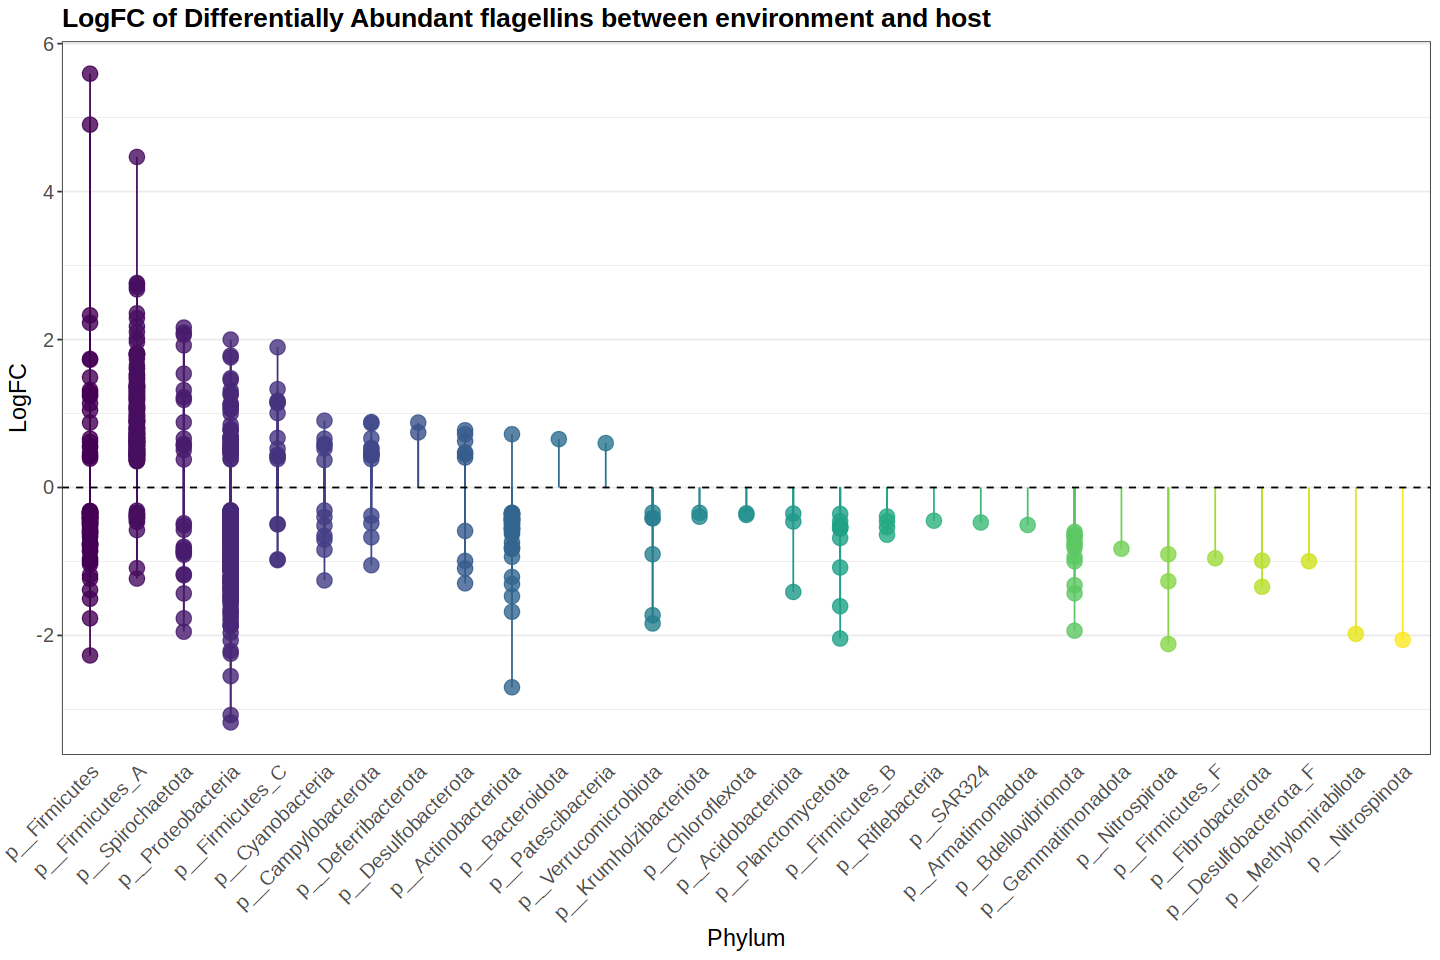

In [318]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.host.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and host")+
  labs(x = "Phylum", y = "LogFC")

In [449]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.biome1=rownames(sigtab.host.env)
psDA_biome1 = prune_taxa(DAs.biome1,nonrare.psAll.filt)
psDA_biome1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 818 taxa and 772 samples ]
sample_data() Sample Data:       [ 772 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 818 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 818 tips and 817 internal nodes ]

#### Create heatmap with DA flagellins

In [450]:
annotations.biome1 = annotationsForHeatmap(psDA_biome1)

In [453]:
matrix = createMatrixForHetmap(psDA_biome1)

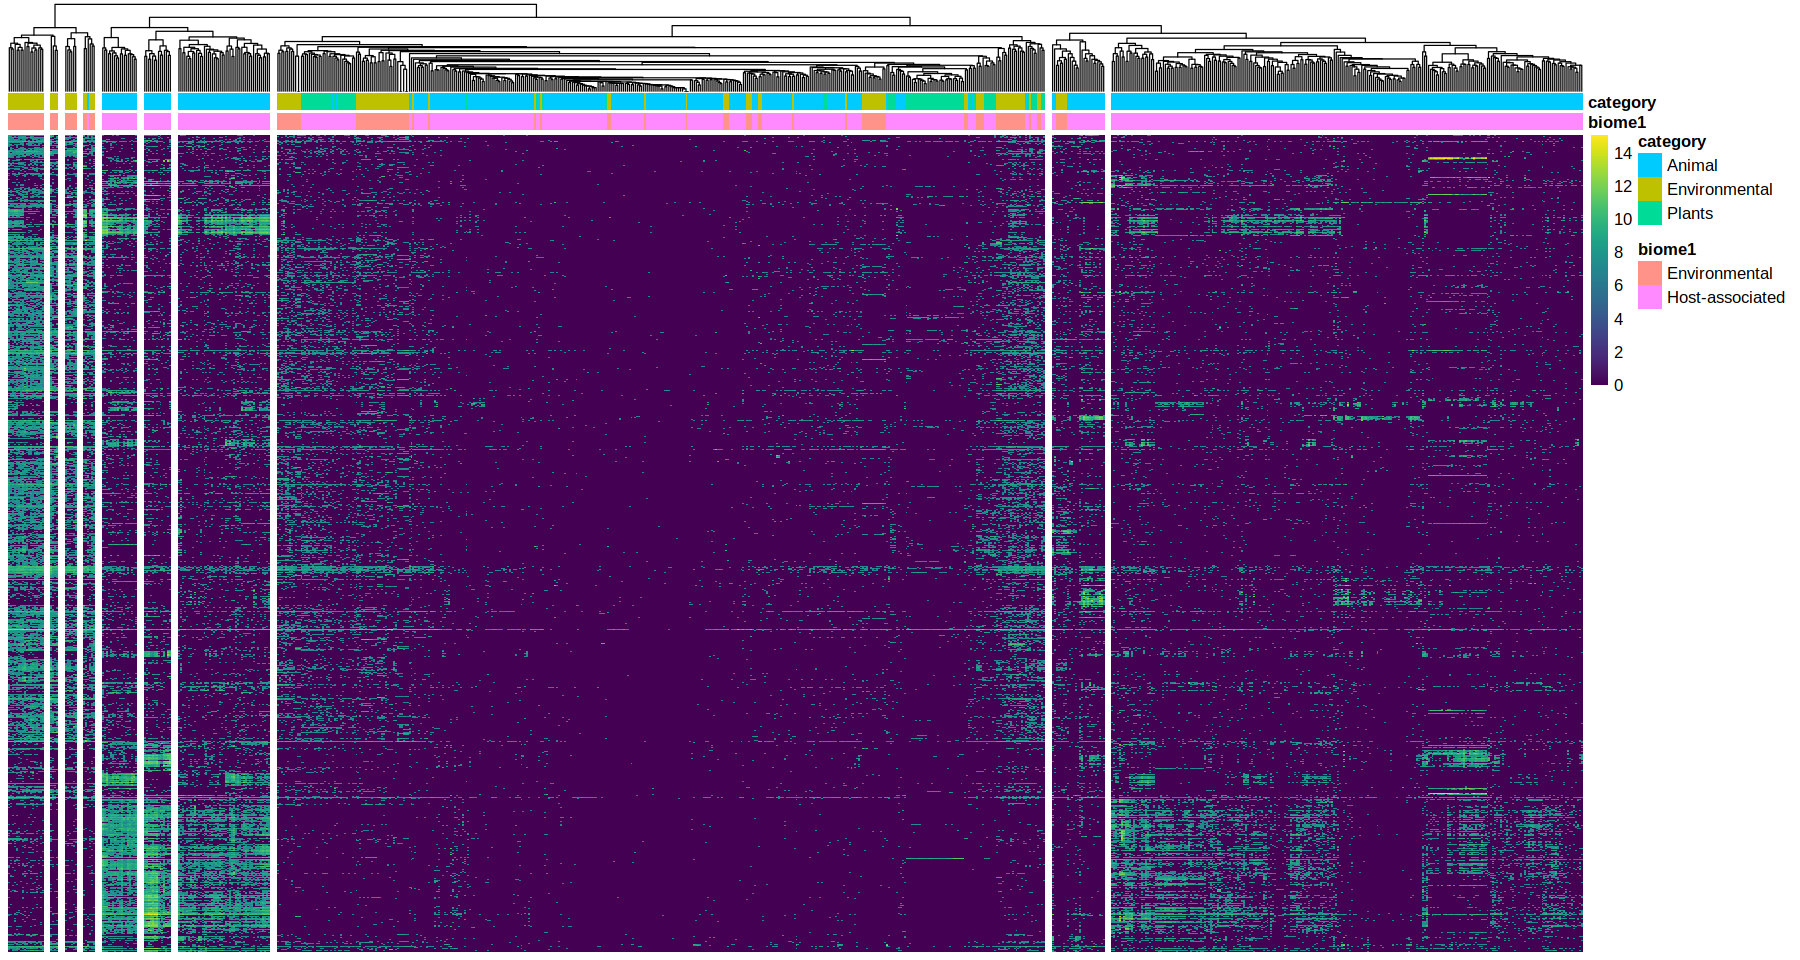

In [457]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome1,category)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 2. Animals/Environmental

In [326]:
ps.animals.env=subset_samples(nonrare.psAll.filt,category!="Plants")
ps.animals.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1453 taxa and 692 samples ]
sample_data() Sample Data:       [ 692 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1453 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1453 tips and 1452 internal nodes ]

In [327]:
#Perform differentially abundance analysis
edger.animal.env = runEdgeR(ps.animals.env,groupToCompare="category")

[1] "Animal"        "Environmental"
[1] "BH"
[1] "exact"


In [328]:
#Table with DA flagellins
sigtab.animal.env = edger.animal.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.animal.env = edger.animal.env$sigtabgen

In [329]:
nrow(sigtabgen.animal.env)

[1] 836

In [330]:
head(sigtab.animal.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232712,11.23155,3.587314e-170,5.212367e-167
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681724,11.22238,2.219539e-140,1.612495e-137
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.804922,11.85652,1.202891e-135,5.826000e-133
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110901,14.10898,7.328518e-106,2.662084e-103
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.549817,10.96601,1.340637e-103,3.895890e-101
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344562,11.36745,7.111249e-99,1.722107e-96


#### Export list of Differentially Abundant flagellins

In [331]:
DA.animals.env = rownames_to_column(sigtab.animal.env,var = "Accession")
#write_tsv(DA.animals.env,"edgeR/DA.animals.env.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


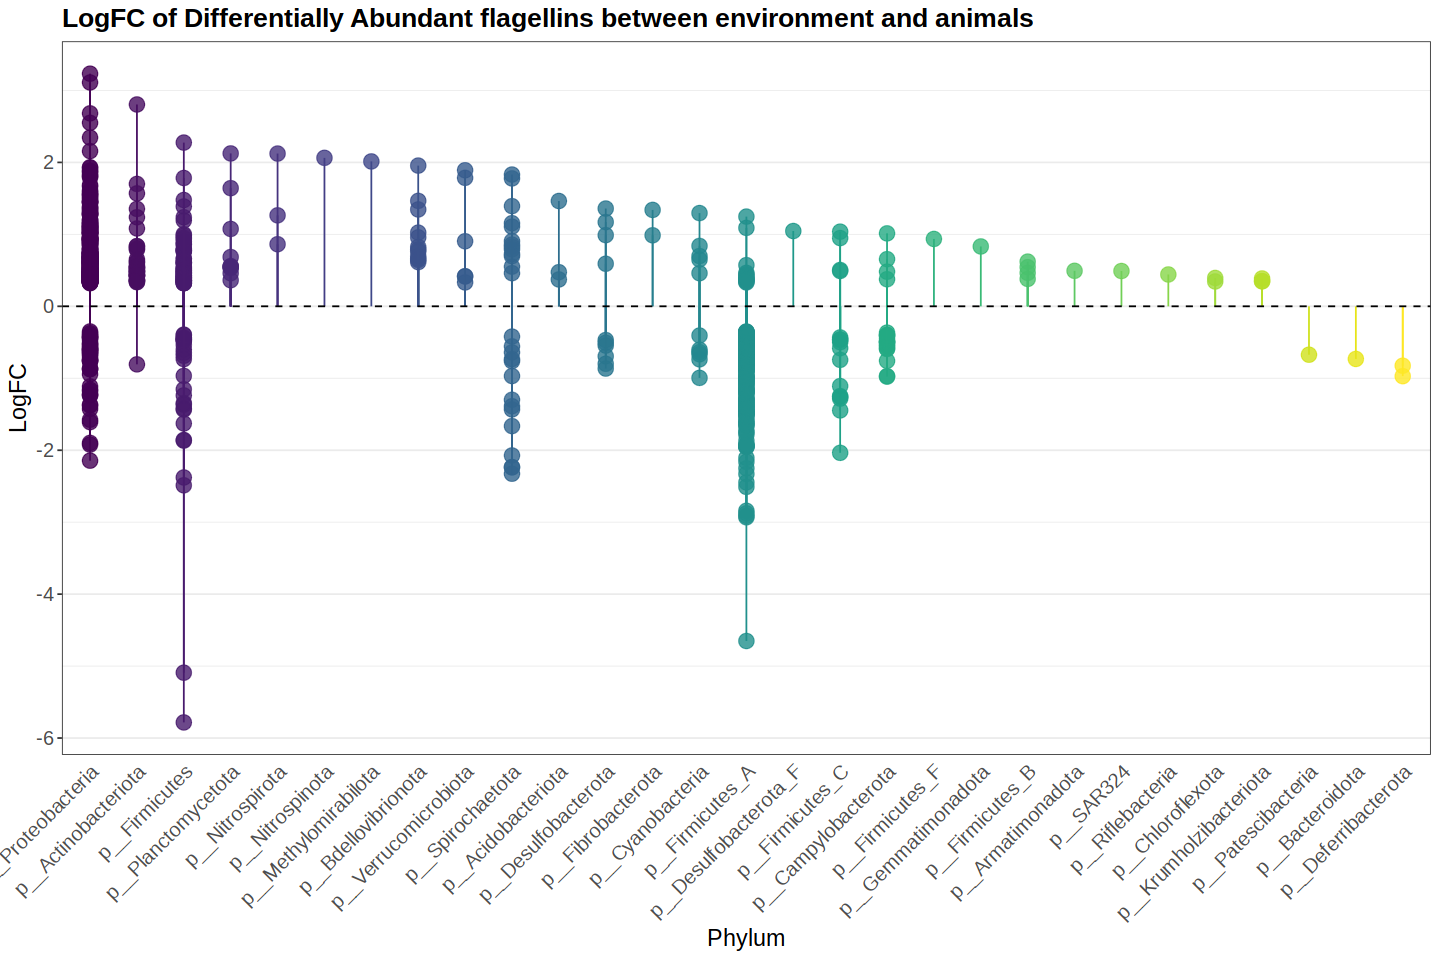

In [332]:
options(repr.plot.width=12,repr.plot.height=8)
ggplot(sigtabgen.animal.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

In [333]:
head(sigtabgen.animal.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232712,11.23155,3.587314e-170,5.212367e-167
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681724,11.22238,2.219539e-140,1.612495e-137
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.804922,11.85652,1.202891e-135,5.826000e-133
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110901,14.10898,7.328518e-106,2.662084e-103
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.549817,10.96601,1.340637e-103,3.895890e-101
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344562,11.36745,7.111249e-99,1.722107e-96


In [334]:
lachnos.env.animals =filter(sigtabgen.animal.env,Family%in%"f__Lachnospiraceae")

In [335]:
nrow(lachnos.env.animals)

[1] 166

Warning message:
“Duplicated aesthetics after name standardisation: xend”


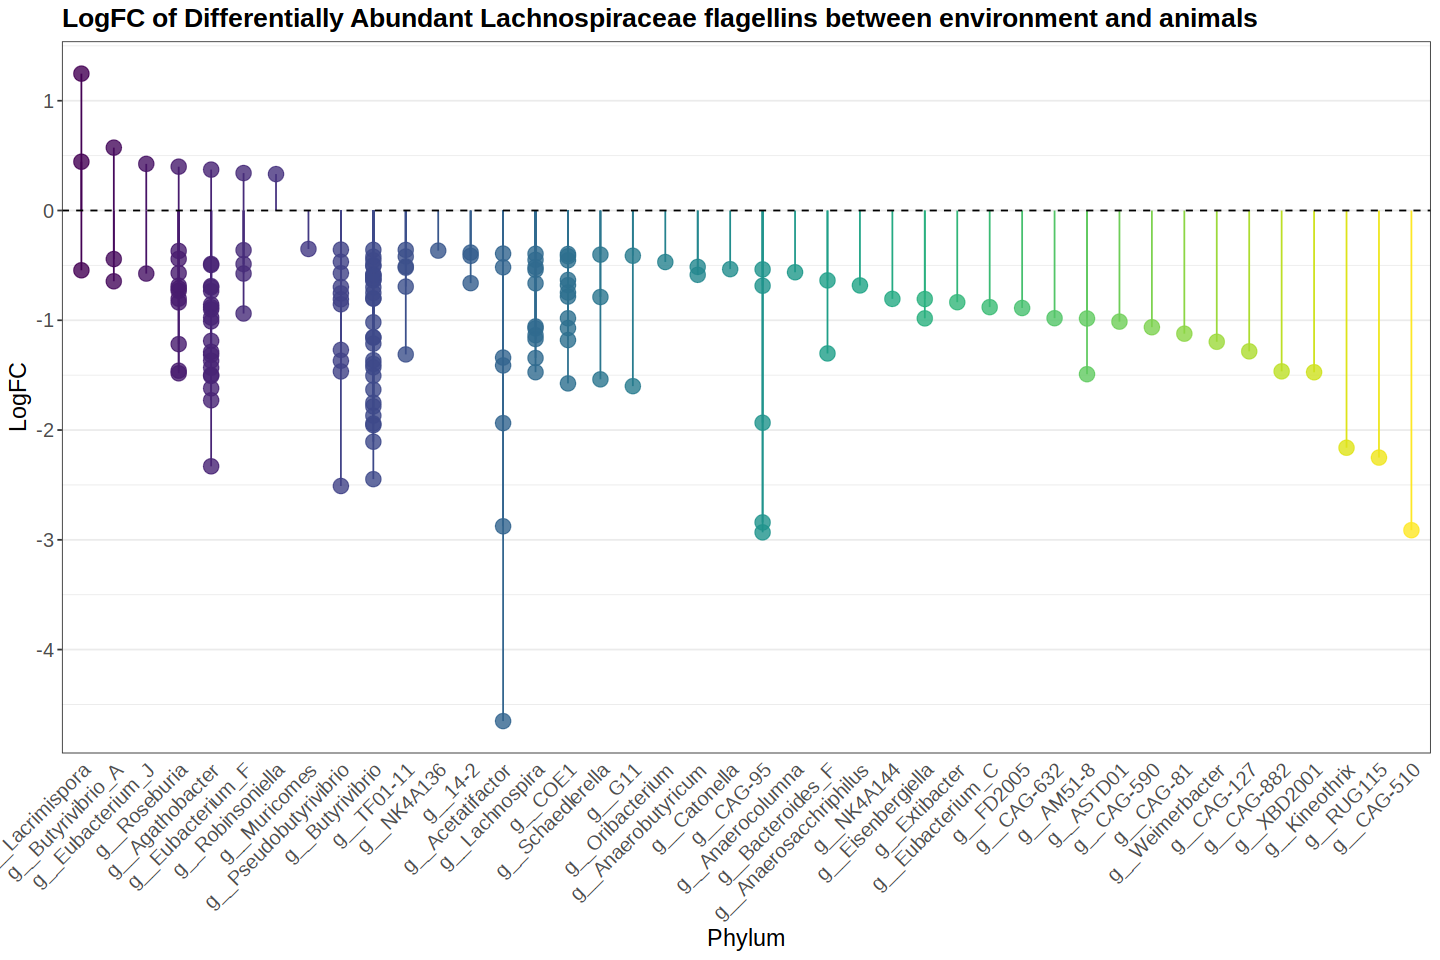

In [336]:
ggplot(lachnos.env.animals, aes(x = Genus, y = logFC, color = Genus)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant Lachnospiraceae flagellins between environment and animals")+
  labs(x = "Phylum", y = "LogFC")

## 3. Plants/Environmental

In [337]:
ps.plants.env=subset_samples(nonrare.psAll.filt,category!="Animal")
ps.plants.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1453 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1453 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1453 tips and 1452 internal nodes ]

In [338]:
#Perform differentially abundance analysis
edger.plants.env = runEdgeR(ps.plants.env,groupToCompare="category")

[1] "Environmental" "Plants"       
[1] "BH"
[1] "exact"


In [339]:
#Table with DA flagellins
sigtab.plants.env = edger.plants.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.plants.env = edger.plants.env$sigtabgen

In [340]:
nrow(sigtabgen.plants.env)

[1] 251

In [341]:
head(sigtab.plants.env)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,3.022458,11.52062,2.827413e-43,4.012099e-40
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,-2.797524,15.35008,2.236956e-33,1.587120e-30
EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.388116,11.51581,1.532382e-28,7.248166e-26
EEO87047.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Yersinia,s__Yersinia pestis,-2.147518,11.89029,6.398392e-25,2.269829e-22
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,-2.758842,12.20582,1.085961e-20,3.081957e-18
WP_043131923.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Aeromonadaceae,g__Aeromonas,s__Aeromonas caviae,-1.965266,11.84183,2.385127e-20,5.640825e-18


#### Export list of Differentially Abundant flagellins

In [342]:
DA.plants.env = rownames_to_column(sigtab.plants.env,var = "Accession")
#write_tsv(DA.plants.env,"edgeR/DA.plants.env.nonrare.filt.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


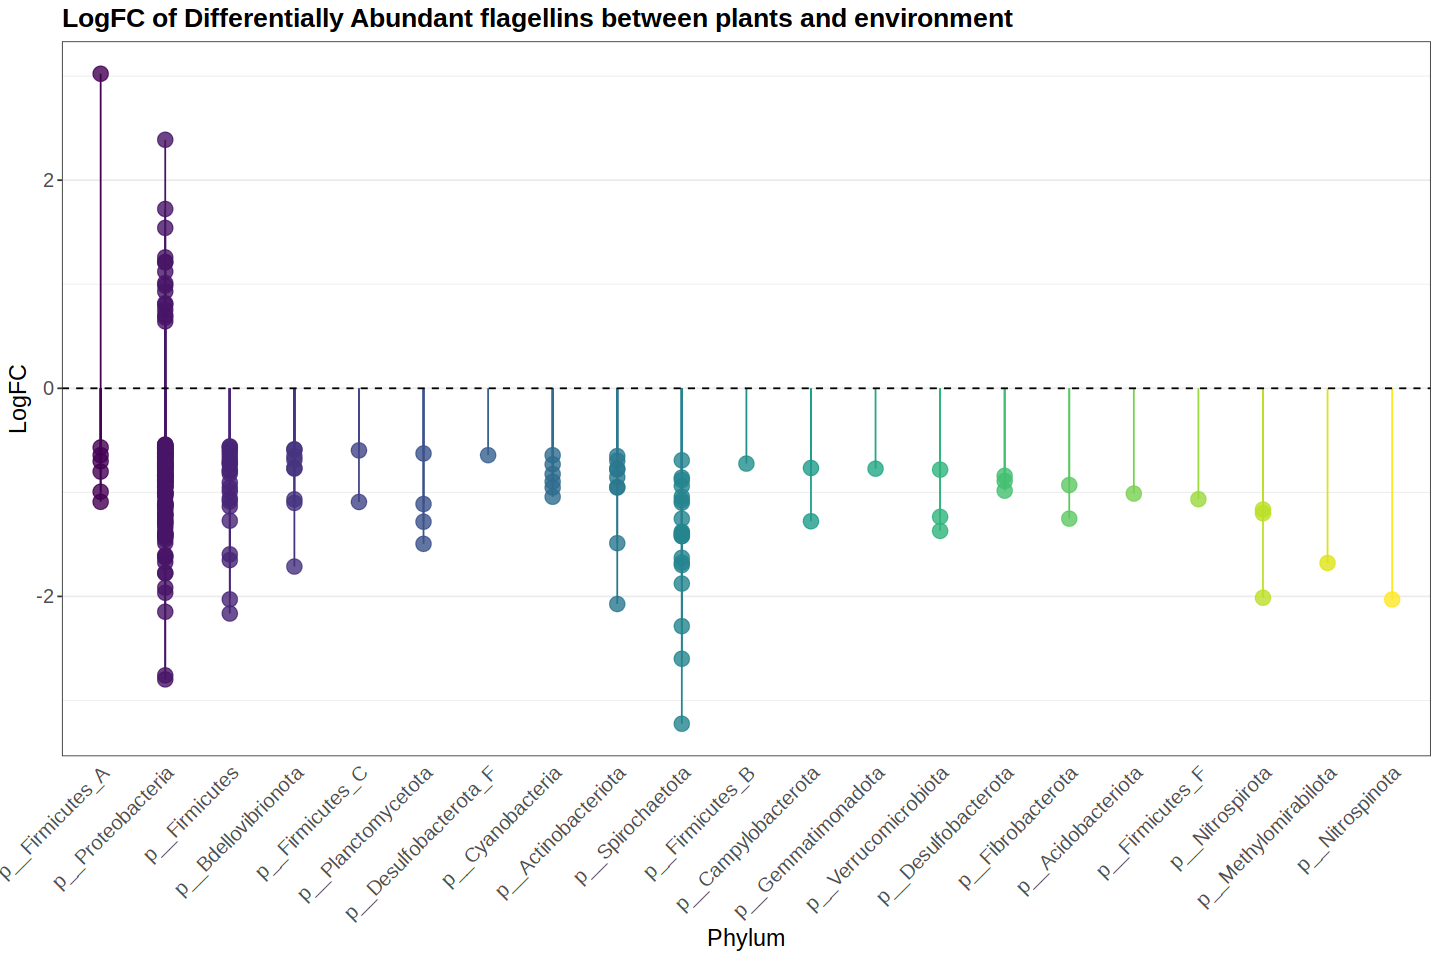

In [343]:
ggplot(sigtabgen.plants.env, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and environment")+
  labs(x = "Phylum", y = "LogFC")

## 4. Plants vs. animals

In [344]:
subset.host.nonrare.filt=subset_samples(nonrare.psAll.filt,biome_1=="Host-associated")

In [345]:
#Perform differentially abundance analysis
edger.host = runEdgeR(subset.host.nonrare.filt,groupToCompare="category")

[1] "Animal" "Plants"
[1] "BH"
[1] "exact"


In [346]:
#Table with DA flagellins
sigtab.host = edger.host$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host = edger.host$sigtabgen

In [347]:
nrow(sigtab.host)

[1] 330

##### Export list of Differentially Abundant flagellins

In [348]:
DA.animalsvsplants = rownames_to_column(sigtab.host,var = "Accession")
#write_tsv(DA.animalsvsplants,"edgeR/DA.animalvsplant.nonrare.filt.tsv")
head(DA.animalsvsplants)

,Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SFH83235.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900113655,2.974236,10.95145,1.226734e-135,1.782444e-132
2,EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.724837,10.94250,1.023206e-111,7.433592e-109
3,KPF42046.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp001296045,1.717866,10.71070,2.694034e-51,1.304811e-48
4,WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,1.648265,10.72021,7.124038e-45,2.587807e-42
5,PPQ20111.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Bradyrhizobium,s__Bradyrhizobium shewense,1.810206,10.71205,2.092111e-44,6.079674e-42
6,ACE93333.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Rhizobium,s__Rhizobium phaseoli,1.430102,10.67491,1.207910e-33,2.925156e-31


#### Plots

##### A. Phlyum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


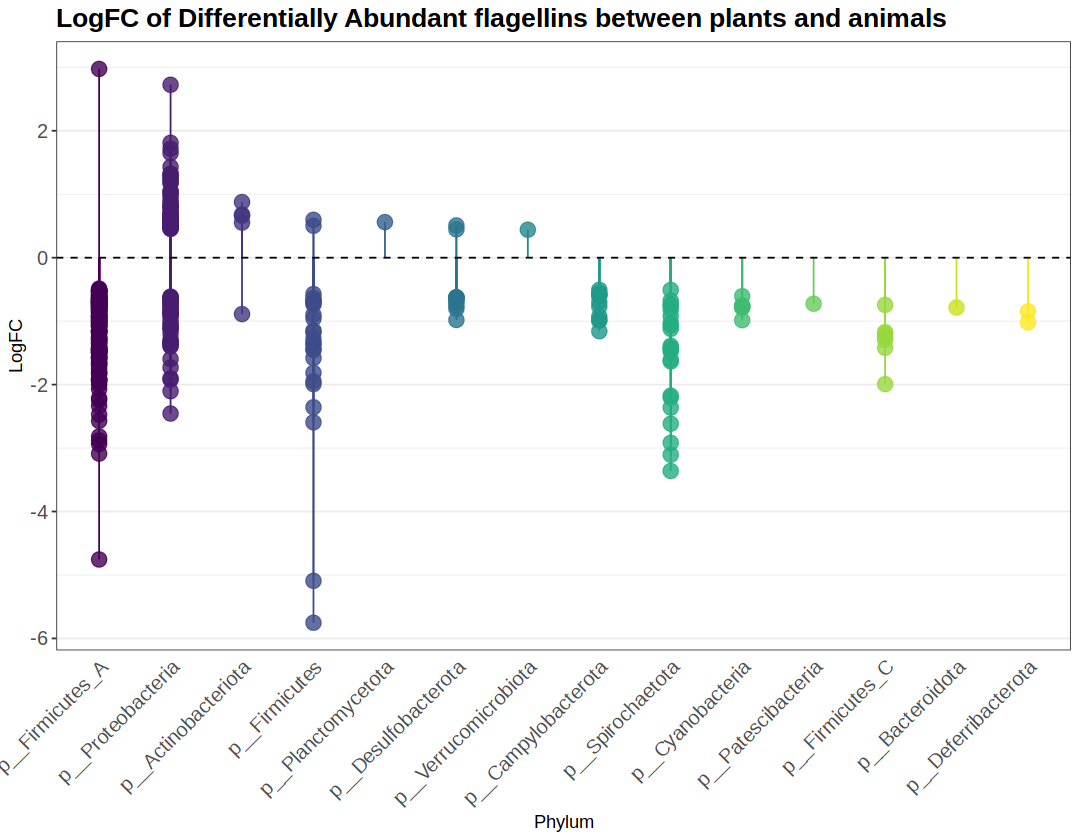

In [349]:
options(repr.plot.width=9,repr.plot.height=7)

ggplot(sigtabgen.host, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")+
  labs(x = "Phylum", y = "LogFC")

##### B. Family-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


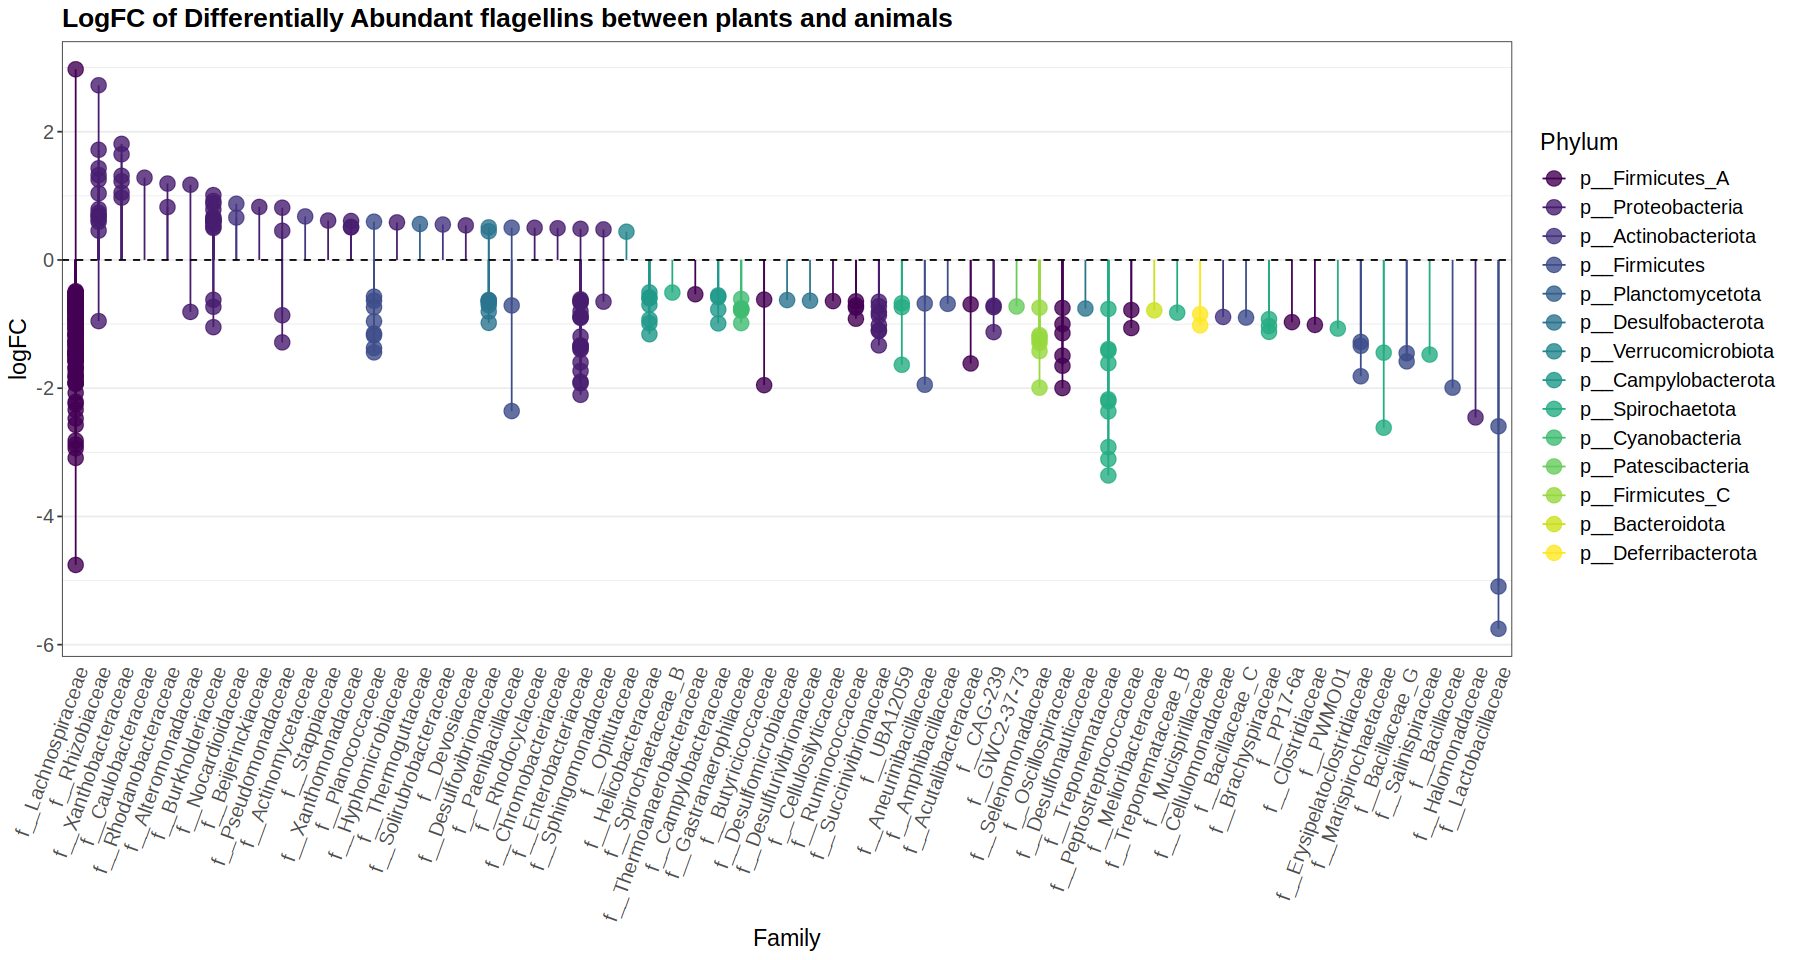

In [350]:
options(repr.plot.width=15,repr.plot.height=8)

ggplot(sigtabgen.host, aes(x = Family, y = logFC, color = Phylum)) + geom_point(size=4,alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Family,xend=Family),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals")

##### C. Genus-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


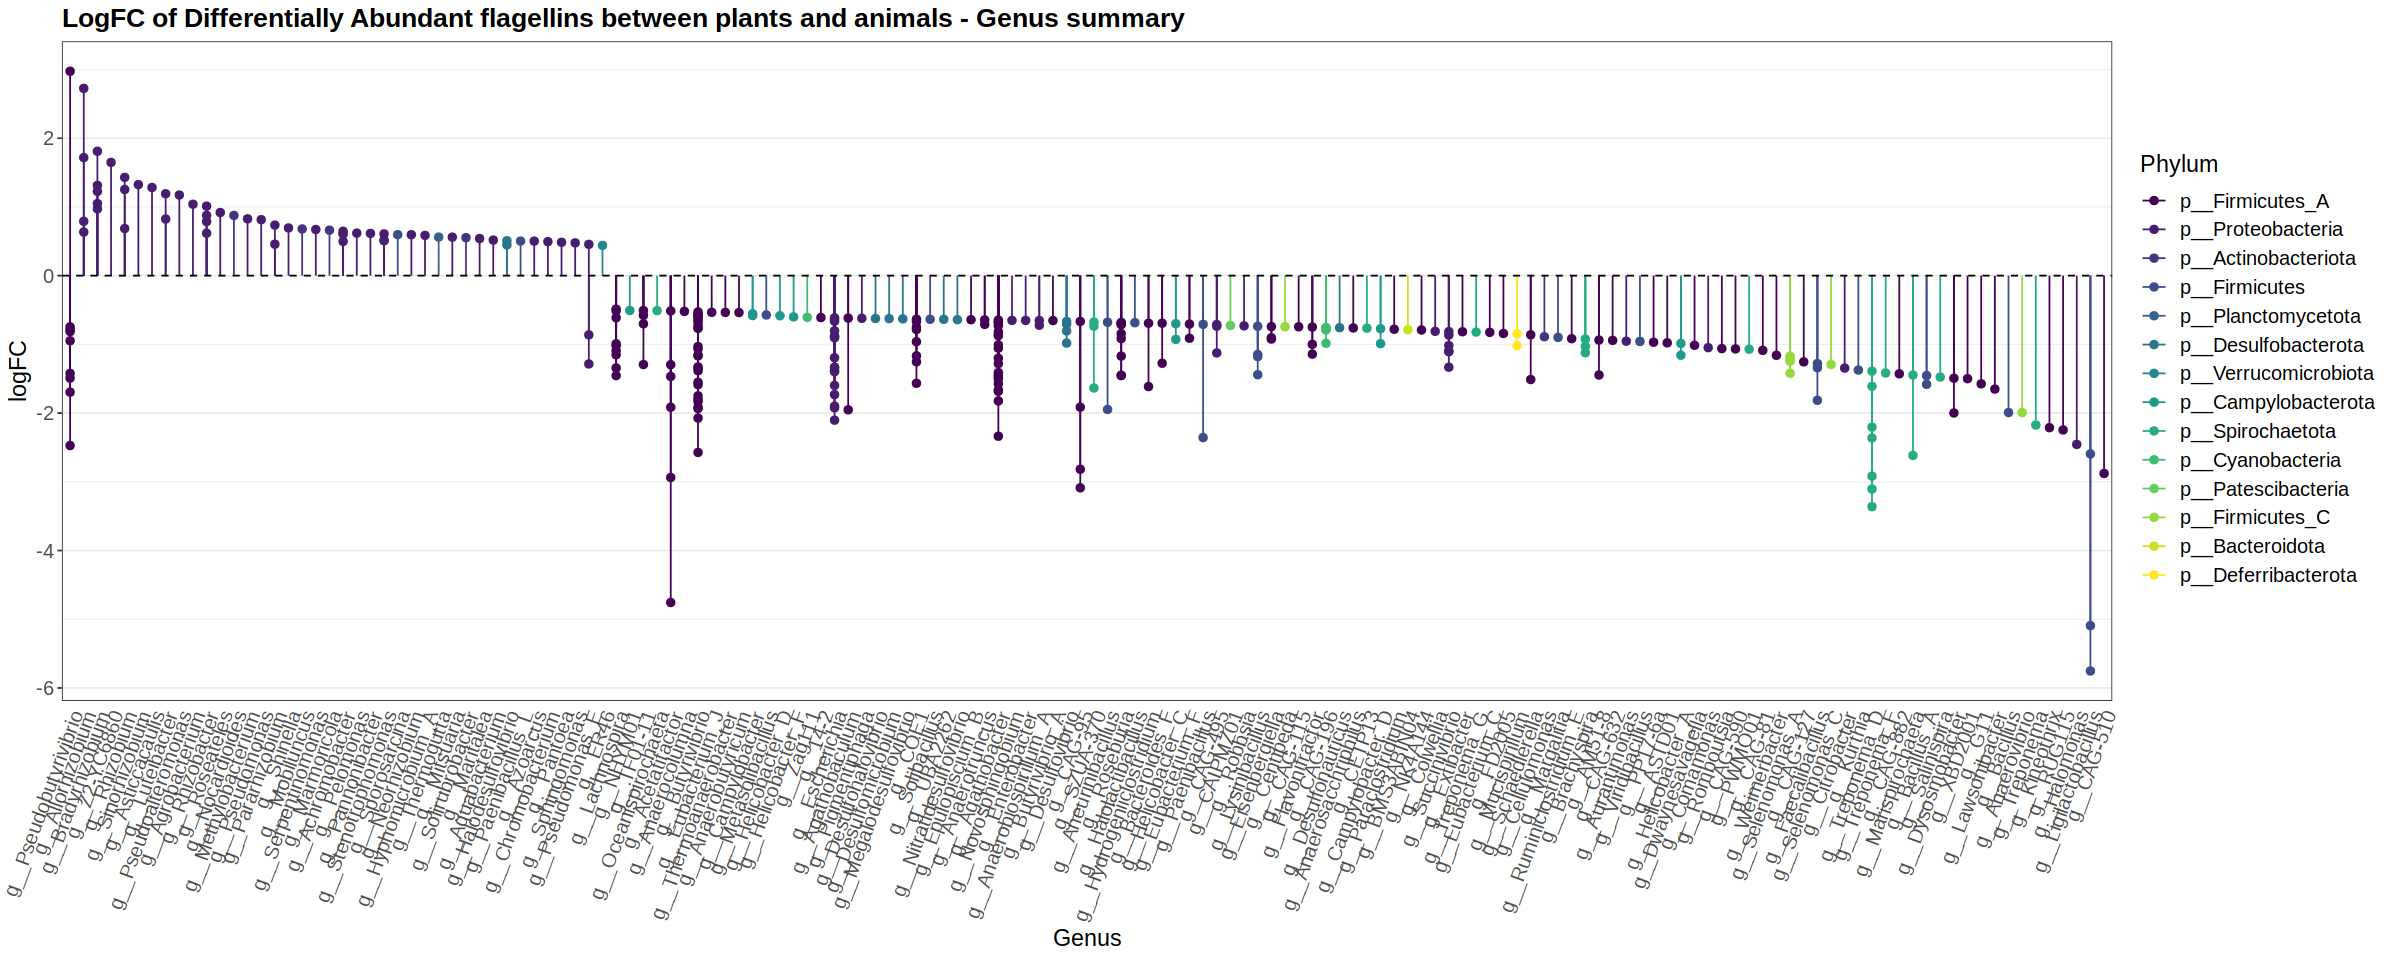

In [351]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host, aes(x = Genus, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals - Genus summary")

##### D. species-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


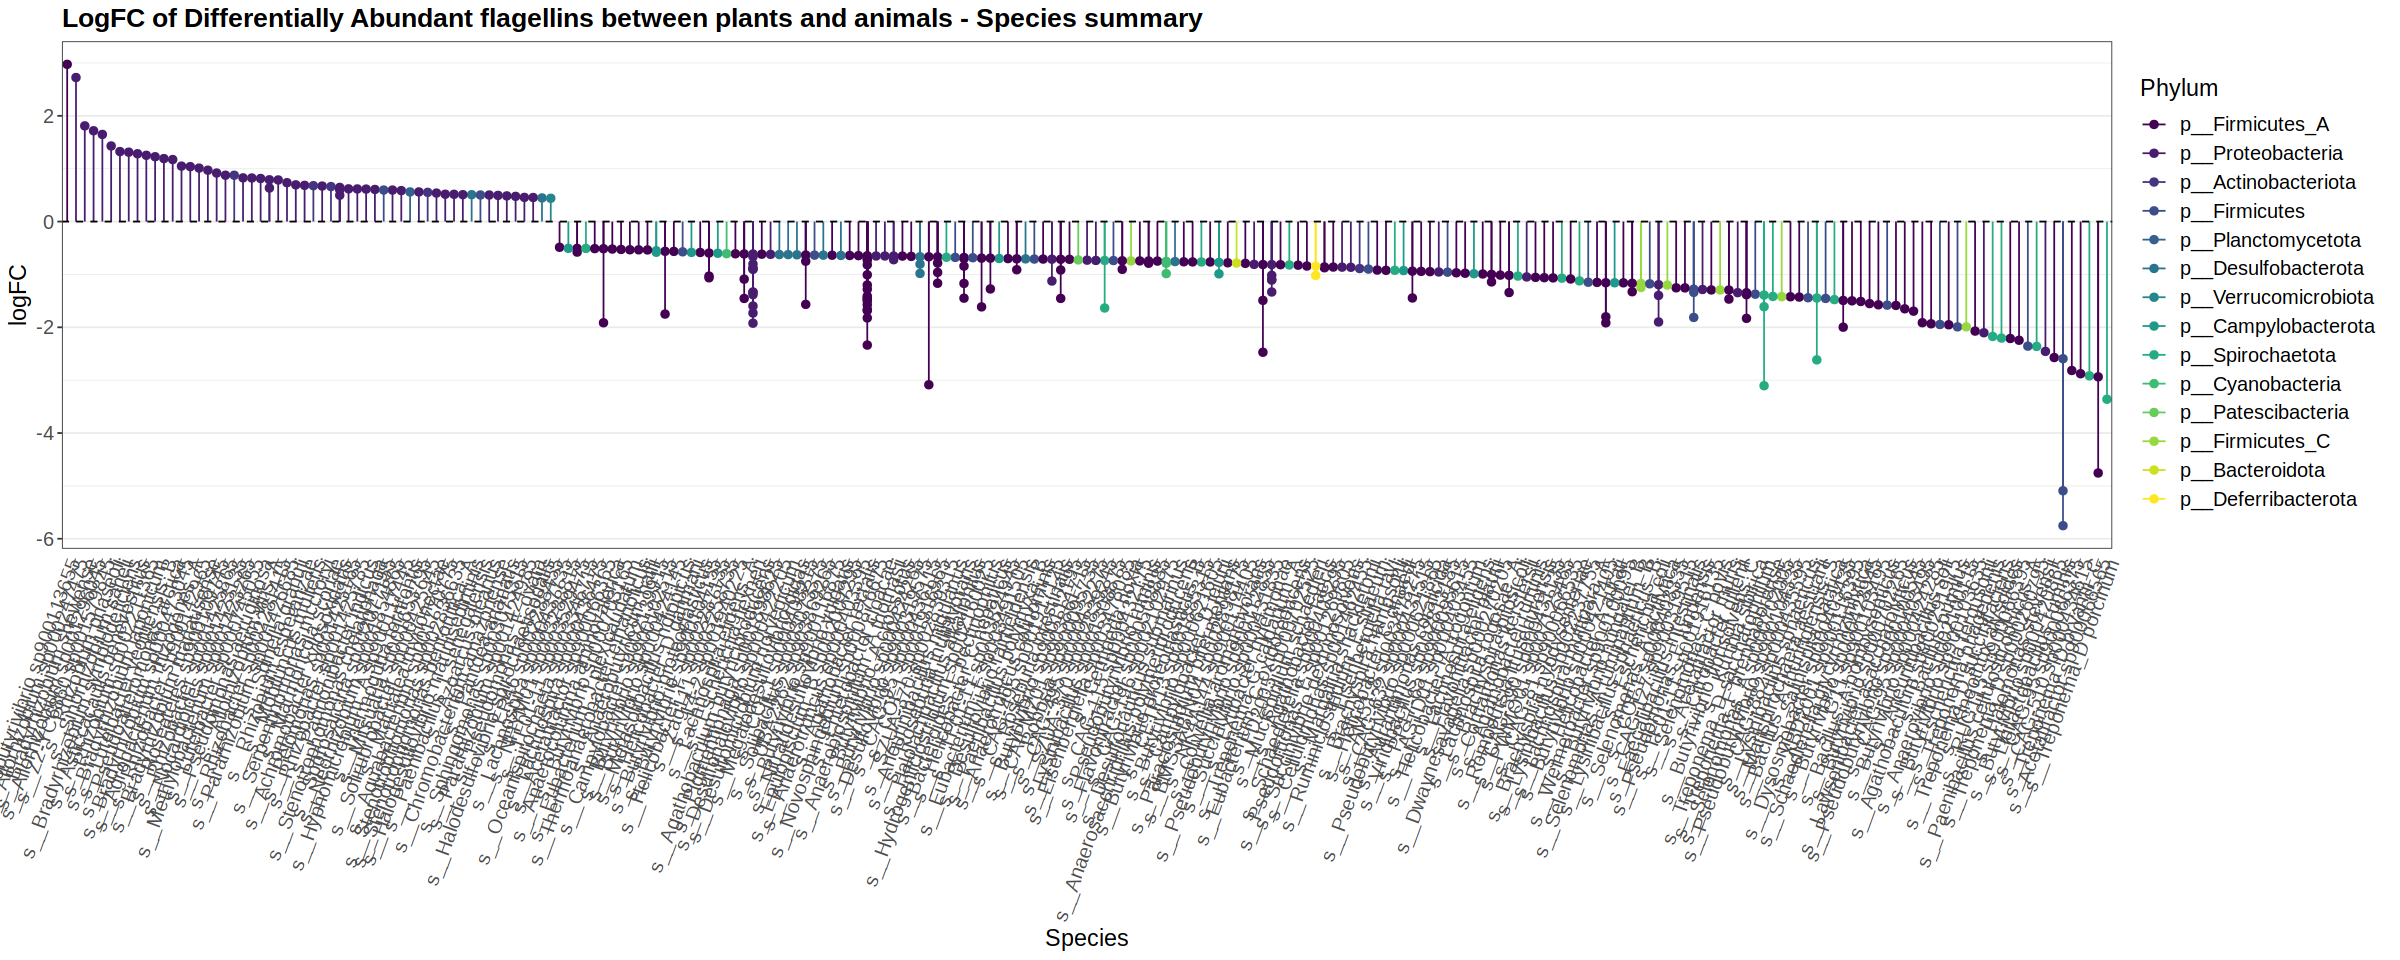

In [352]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host, aes(x = Species, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Species,xend=Species),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals - Species summary")

##### E. Plot hetamaps with DA flagellins

#### Heatmap DAs animal-plants

In [46]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.host=rownames(sigtab.host)
psDA_host = prune_taxa(DAs.host,nonrare.psAll.filt)
psDA_host

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 199 taxa and 358 samples ]
sample_data() Sample Data:       [ 358 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 199 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 199 tips and 198 internal nodes ]

#### Create heatmap with DA flagellins

In [47]:
annotations.host = annotationsForHeatmap(psDA_host)

In [48]:
matrix.host = createMatrixForHetmap(psDA_host)

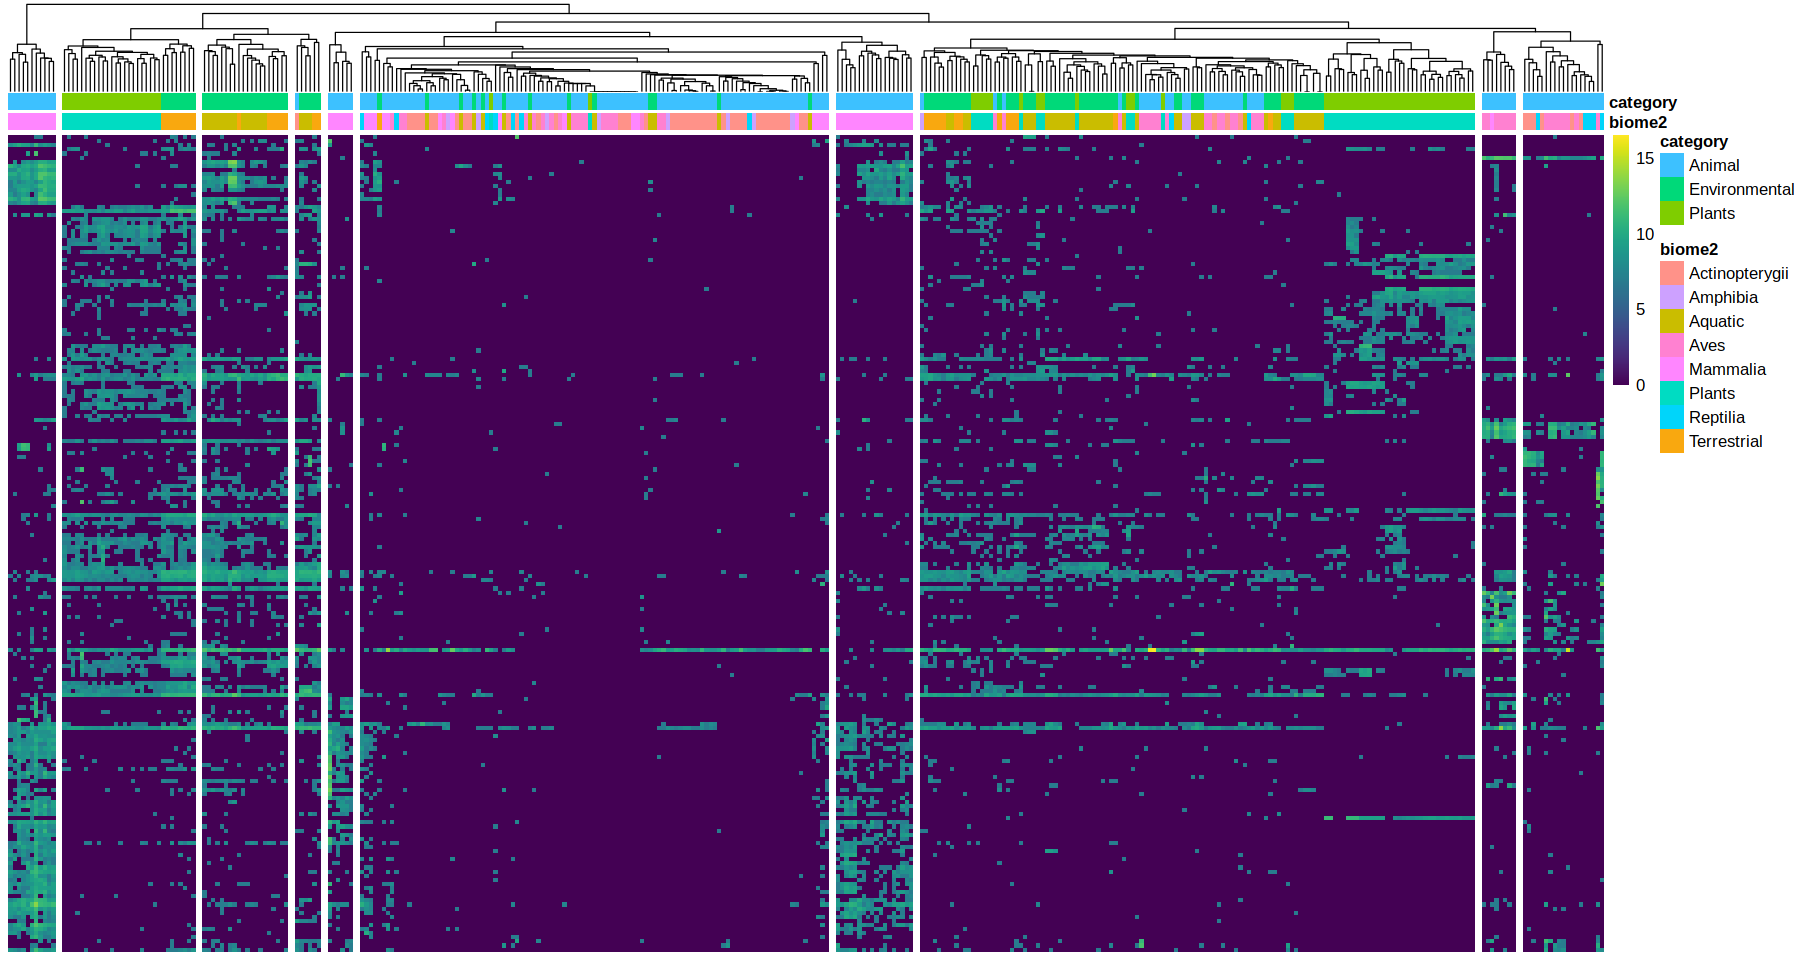

In [49]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix.host, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome2,category)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

## 5. Mammals vs. non-mammals

In [361]:
ps.verts=subset_samples(nonrare.psAll.filt,category=="Animal")
ps.verts

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1453 taxa and 559 samples ]
sample_data() Sample Data:       [ 559 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1453 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1453 tips and 1452 internal nodes ]

In [362]:
#Perform differentially abundance analysis
edger.verts = runEdgeR(ps.verts,groupToCompare="mammals")

[1] "Mammalia" "Others"  
[1] "BH"
[1] "exact"


In [363]:
#Table with DA flagellins
sigtab.verts = edger.verts$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.verts = edger.verts$sigtabgen

In [364]:
nrow(sigtabgen.verts)
nrow(sigtab.verts)

[1] 462

[1] 462

In [365]:
head(sigtab.verts)

,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CAI29258.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri,2.909044,11.43805,3.414405e-79,4.950887e-76
RHP37040.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565,-4.871670,13.98554,2.012723e-71,1.459224e-68
OZY60706.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas_E,s__Pseudomonas_E lundensis,2.548686,11.16358,2.454182e-66,1.186188e-63
SJZ39514.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D porcinum,-3.774763,12.69179,1.037204e-59,3.759864e-57
EFZ33846.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Ligilactobacillus,s__Ligilactobacillus ruminis,-6.255694,14.89643,6.639276e-58,1.925390e-55
RED32195.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Paenibacillales,f__Paenibacillaceae,g__Paenibacillus,s__Paenibacillus cellulositrophicus_A,2.647262,11.89808,7.701916e-57,1.861296e-54


#### Export list of Differentially Abundant flagellins

In [366]:
DA.mammals = rownames_to_column(sigtab.verts,var = "Accession")
#write_tsv(DA.mammals,"edgeR/DA.mammals.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


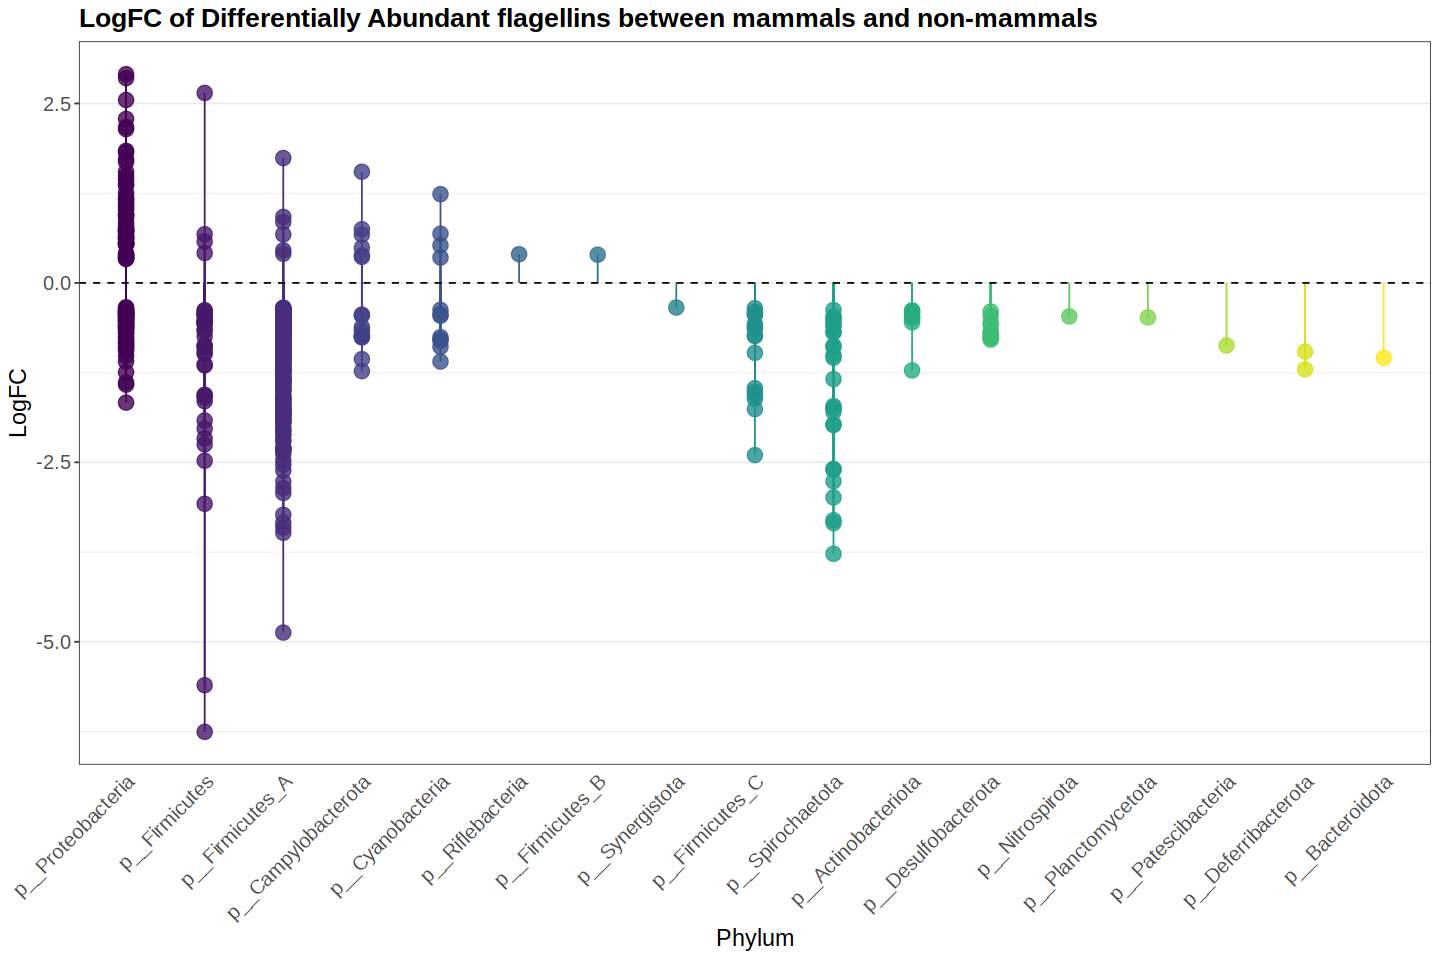

In [367]:
ggplot(sigtabgen.verts, aes(x = Phylum, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Phylum,xend=Phylum),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between mammals and non-mammals")+
  labs(x = "Phylum", y = "LogFC")